<a href="https://colab.research.google.com/github/aqillabf/Data-Scientist/blob/main/LSTM_Climate_Weather_Forescast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

## Load Data and Pre Process

In [ ]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst='dayfirst')
#Ubah menjadi hourly dan buang kolom yang tidak diperlukan
df = df[df['Date Time'].dt.minute==0].reset_index(drop=True).drop(columns=['Tpot (K)', 'Tdew (degC)'])
df.head()

,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
df.tail()

,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
70087,2016-12-31 20:00:00,1001.47,-1.52,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
70088,2016-12-31 21:00:00,1001.29,-3.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
70089,2016-12-31 22:00:00,1000.70,-2.59,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
70090,2016-12-31 23:00:00,1000.21,-3.76,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70
70091,2017-01-01 00:00:00,999.82,-4.82,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.90


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70092 entries, 0 to 70091
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date Time        70092 non-null  datetime64[ns]
 1   p (mbar)         70092 non-null  float64       
 2   T (degC)         70092 non-null  float64       
 3   rh (%)           70092 non-null  float64       
 4   VPmax (mbar)     70092 non-null  float64       
 5   VPact (mbar)     70092 non-null  float64       
 6   VPdef (mbar)     70092 non-null  float64       
 7   sh (g/kg)        70092 non-null  float64       
 8   H2OC (mmol/mol)  70092 non-null  float64       
 9   rho (g/m**3)     70092 non-null  float64       
 10  wv (m/s)         70092 non-null  float64       
 11  max. wv (m/s)    70092 non-null  float64       
 12  wd (deg)         70092 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 7.0 MB


In [ ]:
#Memprediksi Temperature
input_= df[[i for i in df.columns if i not in ['Date Time']]]
target = df['T (degC)'].to_numpy()

#Memastikan data timeseries tidak ter shuffle
X, X_test, y, y_test = train_test_split(input_, target, test_size=0.1, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(53619, 12) (9463, 12) (7010, 12)
(53619,) (9463,) (7010,)


In [ ]:
#Proses Scaling Data
preprocessing = ColumnTransformer([
    ('Pipe',make_pipeline(StandardScaler()), list(input_.columns))
     ])

X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)
X_test_scaled = preprocessing.transform(X_test)

In [ ]:
#Membuat prediksi temperatur 1 jam berikutnya dalam 24 jam (window = 24)
window_len = 24
batch_size = 16
train_gen = TimeseriesGenerator(data=X_train_scaled, targets=y_train, length=window_len, shuffle=False, batch_size=batch_size)
val_gen = TimeseriesGenerator(data=X_val_scaled, targets=y_val, length=window_len, shuffle=False, batch_size=batch_size)
test_gen = TimeseriesGenerator(data=X_test_scaled, targets=y_test, length=window_len, shuffle=False, batch_size=batch_size)

## Pemodelan

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_len, len(input_.columns)), return_sequences = True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

#Learning rate model scheduler
num_epochs = 30
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[tf.metrics.RootMeanSquaredError()])

C:\Users\A C E R\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 256)             │         275,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,049 (1.99 MB)

 Trainable params: 522,049 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stopping],
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/30


C:\Users\A C E R\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3350/3350 ━━━━━━━━━━━━━━━━━━━━ 176s 51ms/step - loss: 32.5789 - root_mean_squared_error: 5.6973 - val_loss: 63.0673 - val_root_mean_squared_error: 7.9415
Epoch 2/30
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 137s 41ms/step - loss: 18.4759 - root_mean_squared_error: 4.2680 - val_loss: 24.2614 - val_root_mean_squared_error: 4.9256
Epoch 3/30
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 132s 39ms/step - loss: 9.9583 - root_mean_squared_error: 3.0909 - val_loss: 2.2330 - val_root_mean_squared_error: 1.4943
Epoch 4/30
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 138s 41ms/step - loss: 3.4296 - root_mean_squared_error: 1.7829 - val_loss: 1.6287 - val_root_mean_squared_error: 1.2762
Epoch 5/30
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 157s 47ms/step - loss: 1.7798 - root_mean_squared_error: 1.2835 - val_loss: 1.0472 - val_root_mean_squared_error: 1.0233
Epoch 6/30
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 139s 41ms/step - loss: 1.2768 - root_mean_squared_error: 1.1096 - val_loss: 0.8880 - val_root_mean_squared_error: 0.9424
Epoch 7/30
3350/3350 ━━━━━━━━

In [ ]:
#save model
model.save('lstm_temperature_new.h5')
#load model
new_model = tf.keras.models.load_model('lstm_temperature_new.h5')

## Predict

In [ ]:
pred = new_model.predict(test_gen).flatten()

C:\Users\A C E R\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


In [ ]:
df_result = X_test[window_len:].copy()
df_result['pred'] = pred
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time', 'T (degC)', 'pred']].set_axis(['Date Time', 'Temperature', 'Prediction'], axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-03-12 21:00:00,0.87,1.340102
63107,2016-03-12 22:00:00,0.88,1.256055
63108,2016-03-12 23:00:00,0.93,1.335225
63109,2016-03-13 00:00:00,1.07,1.384252
63110,2016-03-13 01:00:00,1.07,1.532366


In [ ]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6986 entries, 63106 to 70091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Time    6986 non-null   datetime64[ns]
 1   Temperature  6986 non-null   float64       
 2   Prediction   6986 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(1)
memory usage: 191.0 KB


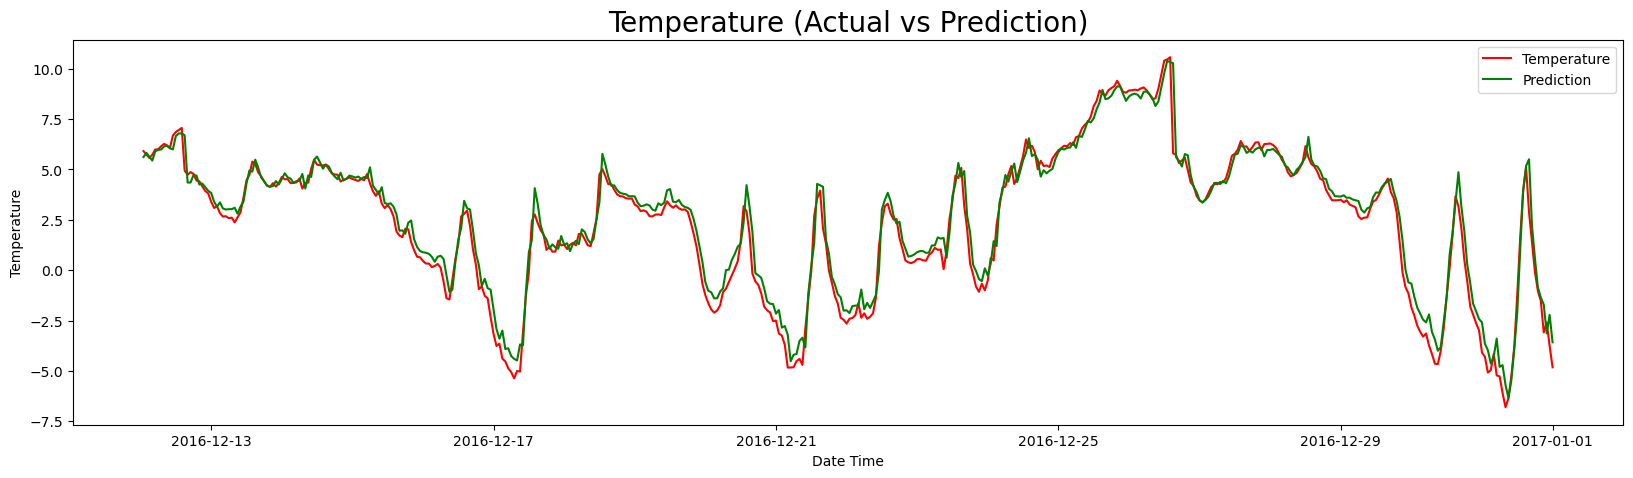

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='red')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='green')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [ ]:
print('R2 :', r2_score(y_true=df_result['Temperature'], y_pred=df_result['Prediction']))
print('RMSE :', mean_squared_error(y_true=df_result['Temperature'], y_pred=df_result['Prediction'], squared=False))

R2 : 0.9898525571208001
RMSE : 0.7895823758488592


C:\Users\A C E R\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
